In [1]:
import re
import unicodedata
import pandas as pd
import nltk

# Visuals 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare
from env import user, password, host

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-whitegrid')

from wordcloud import WordCloud

# 1 Spam Data
## 1.a
**Load the spam data set.**


In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 130.6+ KB


In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [5]:
# how many of the messages are spam vs ham
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels


,n,percent
ham,4825,0.865937
spam,747,0.134063


In [6]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


In [7]:
# Let's break the data up into 3 seperate pieces:

# 1. The words that appear in legitimate text messages.
# 2. The words that appear in spam text messages.
# 3. All of the words.

ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


In [8]:
# transform it into a pandas Series
# use to figure out how often each of the words occur
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [9]:
# Now we'll combine these three together to get one resulting data frame that we can work with:


word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [10]:
# What are the most frequently occuring words?

word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [11]:
# Are there any words that uniquely identify a spam or ham message?

pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])


,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

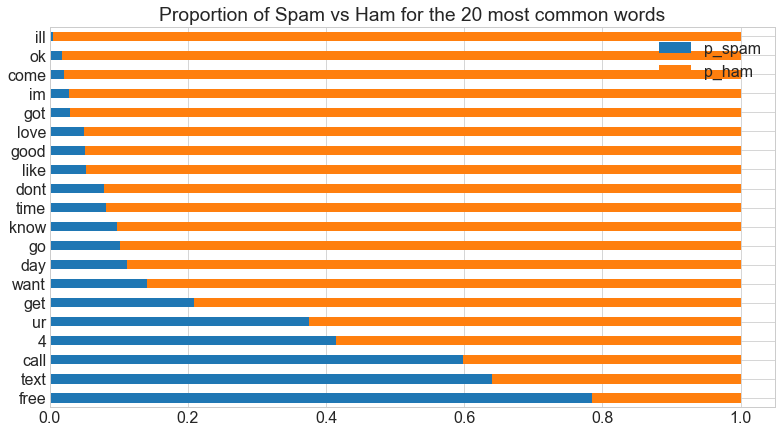

In [12]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

## 1.b
Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?


In [13]:
df.sample()

,label,text
id,,
1734,ham,"I think we're going to finn's now, come"


In [14]:
# spam data bigrams
spam_bigrams = nltk.bigrams(spam_words)

In [15]:
# ham data bigrams
ham_bigrams = nltk.bigrams(ham_words)

<AxesSubplot:>

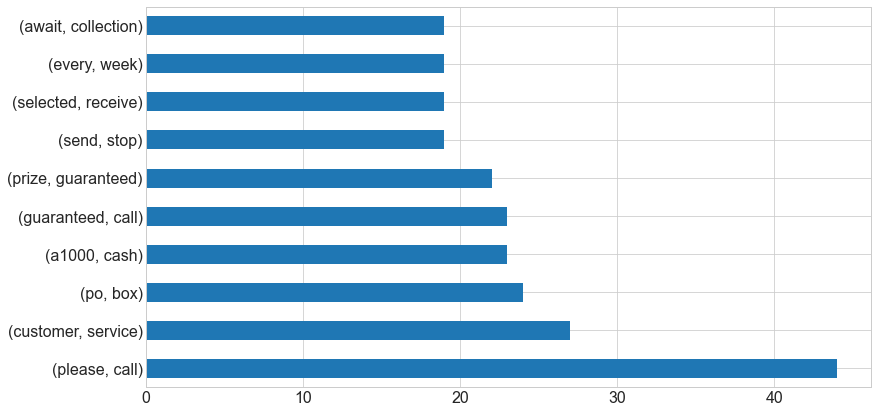

In [16]:
pd.Series(spam_bigrams).value_counts().head(10).plot.barh()

In [17]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

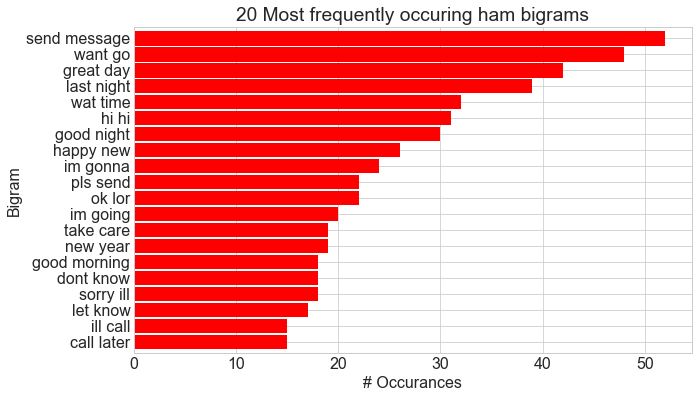

In [18]:
top_20_ham_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [19]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

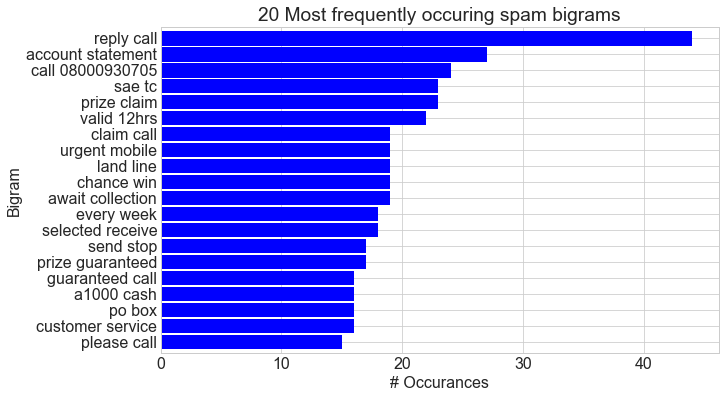

In [20]:
top_20_spam_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

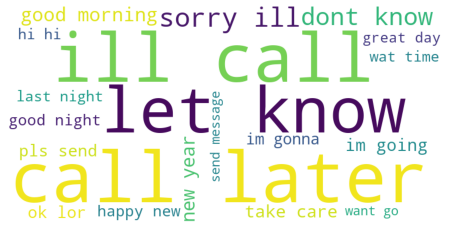

In [21]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

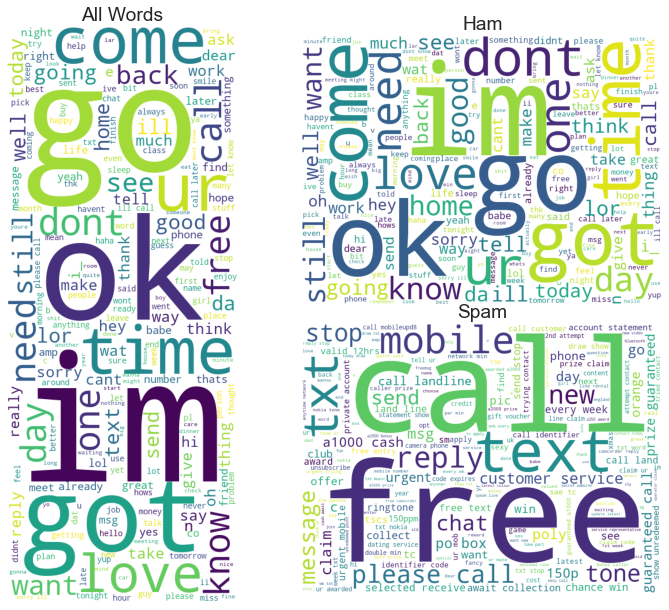

In [22]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

# 1c
Is there any overlap in the bigrams for the spam data and the ham data?

There is some overlap but not that much 

# 1d
Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data

In [23]:
# spam data trigrams
spam_trigrams = nltk.trigrams(spam_words)

In [24]:
# ham  data trigrams
ham_trigrams = nltk.trigrams(ham_words)

In [25]:
# top 20 ham trigrams 
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(right, pls, send)      12
dtype: int64

In [26]:
# top 20 spam trigrams 
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(2003, account, statement)    13
dtype: int64

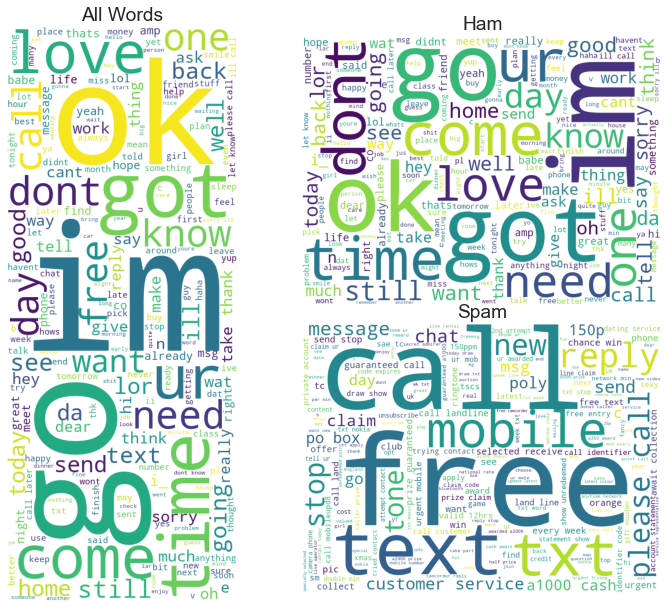

In [27]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

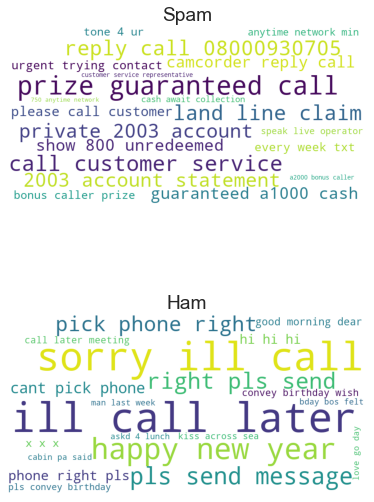

In [28]:
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

data_ham = {k[0] + ' ' + k[1]+' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
data_spam = {k[0] + ' ' + k[1]+' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
ham_cloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data_ham)
spam_cloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data_spam)
plt.figure(figsize=(10, 8))

axs = [plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(spam_cloud)
axs[1].imshow(ham_cloud)

axs[0].set_title('Spam')
axs[1].set_title('Ham')

for ax in axs: ax.axis('off')
plt.show()






# 2 
Explore the blog articles using the techniques discussed in the exploration lesson.

In [29]:
# upload blog data using the aquire module
blog_df = acquire.title_contetn_date_df()
blog_df

,title,content,published_date
0,VET TEC Funding Now Available For Dallas Veter...,We are so happy to announce that VET TEC benef...,"Jan 7, 2022"
1,Codeup Start Dates for March 2022 - Codeup,As we approach the end of January we wanted to...,"Jan 26, 2022"
2,Dallas Campus Re-opens With New Grant Partner ...,We are happy to announce that our Dallas campu...,"Dec 30, 2021"
3,Codeup Helps 40 Grads Land Tech Jobs in Just 1...,Our Placement Team is simply defined as a grou...,"Nov 19, 2021"
4,Is Codeup the Best Bootcamp in San Antonio...o...,Looking for the best data science bootcamp in ...,"Sep 16, 2021"


In [30]:
blog_words = clean(' '.join(blog_df.content))

In [31]:
blog_freq = pd.Series(blog_words).value_counts()
blog_freq

hired        43
developer    24
software     21
associate    19
vet          16
             ..
virtually     1
48            1
better        1
attending     1
handson       1
Length: 553, dtype: int64

In [32]:
blog_counts = pd.DataFrame(blog_freq.fillna(0).astype(int))
blog_counts = blog_counts.reset_index()
blog_counts.rename(columns = {'index': 'word', 0:'count'}, inplace = True)
blog_counts

,word,count
0,hired,43
1,developer,24
2,software,21
3,associate,19
4,vet,16
...,...,...
548,virtually,1
549,48,1
550,better,1
551,attending,1


In [33]:
# blogs bigrams
bigrams = nltk.bigrams(blog_words)
list(bigrams)

[('happy', 'announce'),
 ('announce', 'vet'),
 ('vet', 'tec'),
 ('tec', 'benefit'),
 ('benefit', 'available'),
 ('available', 'used'),
 ('used', 'campus'),
 ('campus', 'located'),
 ('located', 'dallas'),
 ('dallas', 'tx'),
 ('tx', 'next'),
 ('next', 'dallas'),
 ('dallas', 'start'),
 ('start', 'date'),
 ('date', 'web'),
 ('web', 'development'),
 ('development', 'program'),
 ('program', 'january'),
 ('january', '31st'),
 ('31st', '2022'),
 ('2022', 'dont'),
 ('dont', 'want'),
 ('want', 'delay'),
 ('delay', 'application'),
 ('application', 'type'),
 ('type', 'funding'),
 ('funding', 'limited'),
 ('limited', 'apply'),
 ('apply', 'web'),
 ('web', 'development'),
 ('development', 'program'),
 ('program', 'note'),
 ('note', 'interested'),
 ('interested', 'using'),
 ('using', 'vet'),
 ('vet', 'tec'),
 ('tec', 'vet'),
 ('vet', 'tec'),
 ('tec', 'inperson'),
 ('inperson', 'workshop'),
 ('workshop', 'dallas'),
 ('dallas', 'campus'),
 ('campus', '11222'),
 ('11222', 'hosting'),
 ('hosting', 'vet'),

In [34]:
# blogs trigrams
trigrams = nltk.trigrams(blog_words)
list(trigrams)

[('happy', 'announce', 'vet'),
 ('announce', 'vet', 'tec'),
 ('vet', 'tec', 'benefit'),
 ('tec', 'benefit', 'available'),
 ('benefit', 'available', 'used'),
 ('available', 'used', 'campus'),
 ('used', 'campus', 'located'),
 ('campus', 'located', 'dallas'),
 ('located', 'dallas', 'tx'),
 ('dallas', 'tx', 'next'),
 ('tx', 'next', 'dallas'),
 ('next', 'dallas', 'start'),
 ('dallas', 'start', 'date'),
 ('start', 'date', 'web'),
 ('date', 'web', 'development'),
 ('web', 'development', 'program'),
 ('development', 'program', 'january'),
 ('program', 'january', '31st'),
 ('january', '31st', '2022'),
 ('31st', '2022', 'dont'),
 ('2022', 'dont', 'want'),
 ('dont', 'want', 'delay'),
 ('want', 'delay', 'application'),
 ('delay', 'application', 'type'),
 ('application', 'type', 'funding'),
 ('type', 'funding', 'limited'),
 ('funding', 'limited', 'apply'),
 ('limited', 'apply', 'web'),
 ('apply', 'web', 'development'),
 ('web', 'development', 'program'),
 ('development', 'program', 'note'),
 ('prog

In [35]:
top_20_blog_bigrams = (pd.Series(nltk.ngrams(blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_blog_bigrams.head()

(vet, tec)                  15
(java, developer)           14
(hired, accenture)          13
(accenture, federal)        13
(engineering, associate)    10
dtype: int64

In [36]:
# top 20 spam trigrams 
top_20_blog_trigrams = (pd.Series(nltk.ngrams(blog_words, 3))
                      .value_counts()
                      .head(20))

top_20_blog_trigrams.head()

(hired, accenture, federal)           13
(cgi, java, developer)                10
(federal, software, engineering)      10
(software, engineering, associate)    10
(accenture, federal, software)        10
dtype: int64

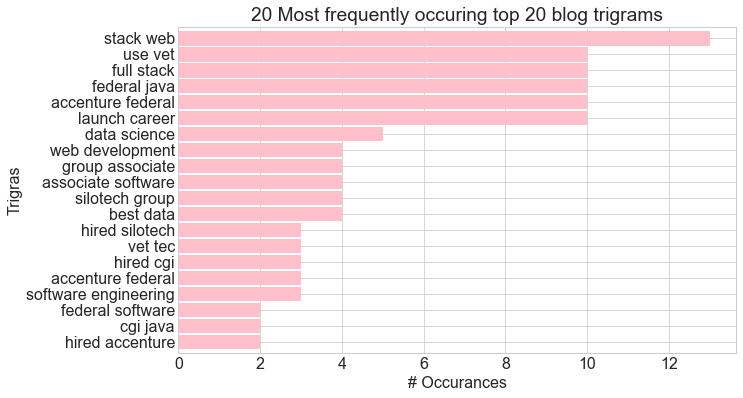

In [37]:
top_20_blog_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring top 20 blog trigrams')
plt.ylabel('Trigras')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_blog_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

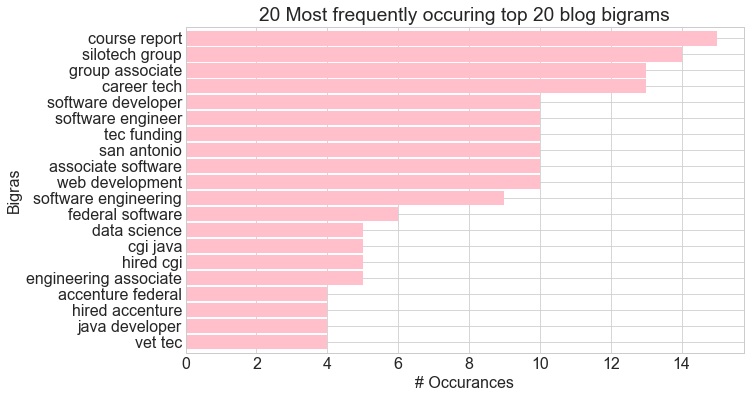

In [38]:
top_20_blog_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring top 20 blog bigrams')
plt.ylabel('Bigras')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_blog_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

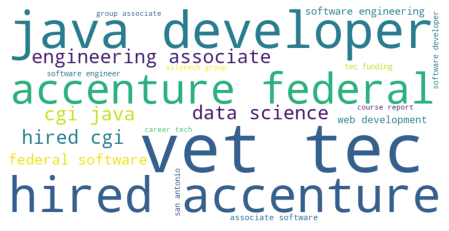

In [39]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

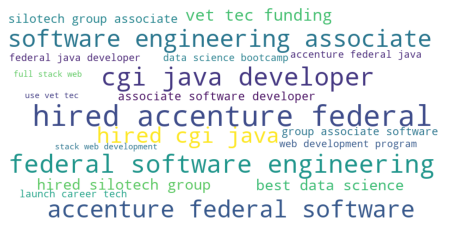

In [40]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_blog_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [41]:
news_df = acquire.get_inshorts_articles()
news_df

,title,author,content,date,category
0,LIC files draft papers with SEBI to seek appro...,Pragya Swastik,State-run Life Insurance Corporation of India ...,"13 Feb 2022,Sunday",business
1,We have lost a visionary: Rahul Gandhi on Rahu...,Shalini Ojha,Former Congress chief Rahul Gandhi condoled th...,"12 Feb 2022,Saturday",business
2,Piyush Goyal shares meme featuring Shark Tank'...,Apaar Sharma,Union Minister Piyush Goyal has shared a Shark...,"13 Feb 2022,Sunday",business
3,"I've made multi-billion dollar businesses, it ...",Daisy Mowke,"Speaking on Figuring Out podcast, BharatPe Co-...","12 Feb 2022,Saturday",business
4,13-yr-old girl gets ₹50 lakh funding on Shark ...,Ridham Gambhir,A Class 8 girl became the youngest contestant ...,"13 Feb 2022,Sunday",business
...,...,...,...,...,...
93,"I don't want the pressure of lineage, legacy: ...",Kriti Kambiri,Veteran actor Mithun Chakraborty's son Namashi...,"13 Feb 2022,Sunday",entertainment
94,She never forgot him: Madhubala's sister on Di...,Mahima Kharbanda,Legendary actress Madhubala's sister Madhur Bh...,"13 Feb 2022,Sunday",entertainment
95,'Gehraiyaan' is a deeper look into modern rela...,Amartya Sharma,"Talking about 'Gehraiyaan', actress Pavleen Gu...","13 Feb 2022,Sunday",entertainment
96,Andrew & I ate lunch facing wall to avoid Spid...,Kriti Kambiri,Actor Charlie Cox has revealed that he once at...,"13 Feb 2022,Sunday",entertainment


In [42]:
news_words = clean(' '.join(news_df.content))

In [43]:
news_freq = pd.Series(news_words).value_counts()
news_freq

said           68
crore          45
ipl            38
auction        38
added          31
               ..
claim           1
mumbaibased     1
talked          1
china           1
participant     1
Length: 1904, dtype: int64

In [44]:
news_counts = pd.DataFrame(news_freq.fillna(0).astype(int))
news_counts = news_counts.reset_index()
news_counts.rename(columns = {'index': 'word', 0:'count'}, inplace = True)
news_counts

,word,count
0,said,68
1,crore,45
2,ipl,38
3,auction,38
4,added,31
...,...,...
1899,claim,1
1900,mumbaibased,1
1901,talked,1
1902,china,1


In [45]:
# how many of the messages are spam vs ham
labels = pd.concat([news_df.category.value_counts(),
                    news_df.category.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
entertainment,25,0.255102
business,25,0.255102
technology,24,0.244898
sports,24,0.244898


In [46]:
show_counts_and_ratios(news_df, "category")

,n,percent
entertainment,25,0.255102
business,25,0.255102
technology,24,0.244898
sports,24,0.244898


In [47]:
news_df.category.unique()

array(['business', 'sports', 'technology', 'entertainment'], dtype=object)

In [53]:
news_df.columns

Index(['title', 'author', 'content', 'date', 'category'], dtype='object')

In [57]:
# Let's break the data up into 3 seperate pieces:

# 1. The words that appear in legitimate text messages.
# 2. The words that appear in spam text messages.
# 3. All of the words.
business_words = clean(' '.join(news_df[news_df.category == 'business'].content))
sports_words = clean(' '.join(news_df[news_df.category == 'sports'].content))
technology_words = clean(' '.join(news_df[news_df.category == 'technology'].content))
entertainment_words = clean(' '.join(news_df[news_df.category == 'entertainment'].content))
all_words = clean(' '.join(news_df.content))

In [58]:
# transform it into a pandas Series
# use to figure out how often each of the words occur
business_freq = pd.Series(business_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
technology_freq = pd.Series(technology_words).value_counts()
entertainment_freq = pd.Series(entertainment_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

technology_freq.head()

said     17
u        13
year      9
india     9
share     8
dtype: int64

In [59]:
word_counts = (pd.concat([business_freq, sports_freq, technology_freq, entertainment_freq, all_freq], axis=1, sort=True)
                .set_axis(['business', 'sports', 'technology', 'entertainment', 'all'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,business,sports,technology,entertainment,all
1,2,3,1,0,6
10,2,3,3,1,9
100,0,1,0,0,1
10080,1,0,0,0,1
104,0,0,0,1,1


In [60]:
# What are the most frequently occuring words?

word_counts.sort_values(by='all', ascending=False).head(10)

,business,sports,technology,entertainment,all
said,10,11,17,30,68
crore,15,30,0,0,45
auction,2,33,3,0,38
ipl,0,38,0,0,38
added,6,8,6,11,31
india,13,7,9,0,29
2022,2,26,1,0,29
mega,0,24,0,0,24
bought,0,19,1,0,20
day,3,5,1,10,19


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

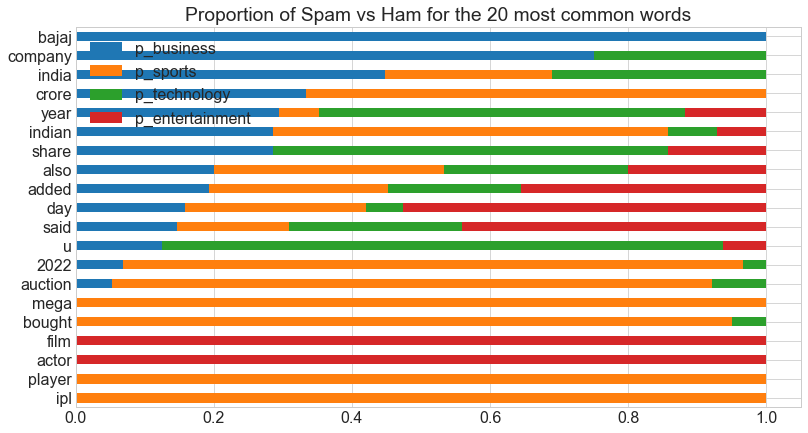

In [63]:
# figure out the percentage of words by category
(word_counts
 .assign(p_business=word_counts.business / word_counts['all'],
         p_sports=word_counts.sports / word_counts['all'],
         p_technology=word_counts.technology / word_counts['all'],
         p_entertainment=word_counts.entertainment / word_counts['all'])
 .sort_values(by='all')
 [['p_business', 'p_sports', 'p_technology', 'p_entertainment']]
 .tail(20)
 .sort_values('p_business')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')